# Final Combined Model and Test Set Evaluation


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Set memory growth to avoid OOM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [13]:
DATA_DIR = "E:\\archive\\chest_xray"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "val")
test_dir = os.path.join(DATA_DIR, "test")


## Load Data


In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

val_ds_split = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

val_ds_dir = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

val_ds = val_ds_split.concatenate(val_ds_dir)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = ['NORMAL', 'PNEUMONIA']
print(f"Classes: {class_names}")


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


## Data Augmentation


In [15]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
])


## Build Combined Model


In [16]:
def build_cnn_model(
    input_shape=IMG_SIZE + (3,),
    num_filters=(16, 32),
    dense_units=64,
    dropout_rate=0.5,
):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    for i, f in enumerate(num_filters):
        if i == 0:
            x = layers.Conv2D(f, 3, strides=2, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D()(x)
        else:
            x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

model = build_cnn_model()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 96 (384.00 B)

## Class Weights


In [17]:
normal_count = 1341
pneu_count = 3875
total = normal_count + pneu_count

class_weight = {
    0: total / (2 * normal_count),
    1: total / (2 * pneu_count),
}


## Train Model


In [18]:
MODEL_PATH = 'final_combined_model.keras'

if os.path.exists(MODEL_PATH):
    print(f"Loading {MODEL_PATH}...")
    model = keras.models.load_model(MODEL_PATH)
else:
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            MODEL_PATH, 
            save_best_only=True
        ),
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )
    
    best_epoch = np.argmin(history.history['val_loss'])
    print(f"\nBest epoch: {best_epoch + 1}")
    print(f"Best val_accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
    print(f"Best val_loss: {history.history['val_loss'][best_epoch]:.4f}")


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.5826 - auc_1: 0.7187 - loss: 0.6307 - precision_1: 0.8598 - recall_1: 0.5193 - val_accuracy: 0.9924 - val_auc_1: 0.7124 - val_loss: 0.6095 - val_precision_1: 0.9924 - val_recall_1: 1.0000
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7227 - auc_1: 0.8325 - loss: 0.5436 - precision_1: 0.9219 - recall_1: 0.6822 - val_accuracy: 0.9924 - val_auc_1: 0.7647 - val_loss: 0.4433 - val_precision_1: 0.9924 - val_recall_1: 1.0000
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7743 - auc_1: 0.8675 - loss: 0.4844 - precision_1: 0.9339 - recall_1: 0.7472 - val_accuracy: 0.9877 - val_auc_1: 0.7702 - val_loss: 0.4008 - val_precision_1: 0.9924 - val_recall_1: 0.9952
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.7977 - auc_1: 0.8859 - loss: 0.4472 - precision_1: 0.9433 - recall_1: 0.7725 - val_accuracy: 0.9046 - val_auc_1: 0.7727 - val_loss: 0.3698 - val_precision_1: 0.9927 - 

## Test Set Evaluation


### Get Predictions


In [19]:
y_true = []
y_pred_proba = []

for images, labels in test_ds:
    y_true.extend(labels.numpy().flatten())
    preds = model.predict(images, verbose=0)
    y_pred_proba.extend(preds.flatten())

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f"Test samples: {len(y_true)}")


Test samples: 624


### Confusion Matrix

The confusion matrix provides a detailed breakdown of the model's predictions, showing true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). This helps understand the model's performance across both classes.

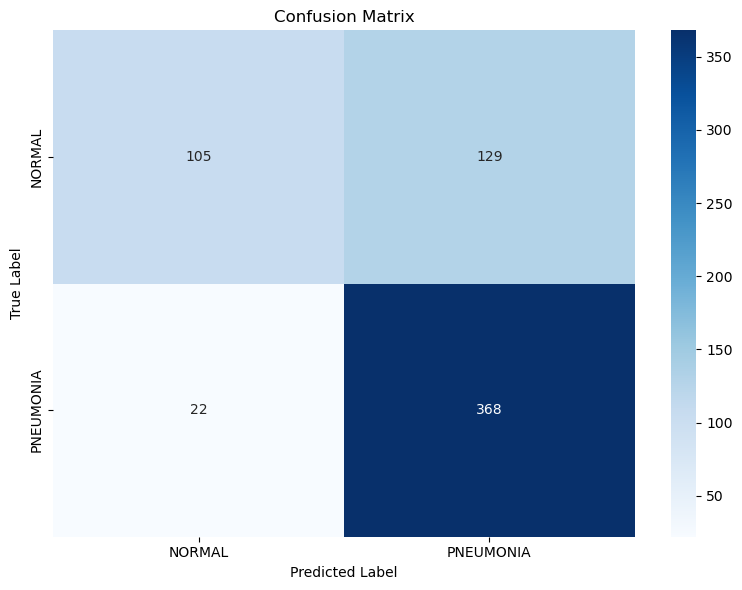

TN: 105, FP: 129, FN: 22, TP: 368


In [20]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


**Results Summary:** The model correctly identified 368 pneumonia cases (TP) and 105 normal cases (TN). It produced 129 false positives (normal cases incorrectly classified as pneumonia) and 22 false negatives (pneumonia cases missed). This indicates the model has high sensitivity (94.36%) but lower specificity (44.87%), meaning it prioritizes detecting pneumonia cases over correctly identifying normal cases.


### Classification Metrics

Classification metrics provide a comprehensive evaluation of model performance. Accuracy measures overall correctness, precision indicates the reliability of positive predictions, recall shows the model's ability to find all positive cases, and the F1 score balances precision and recall.


In [21]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("=" * 60)
print("CLASSIFICATION METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


CLASSIFICATION METRICS
Accuracy:  0.7580
Precision: 0.7404
Recall:   0.9436
F1 Score: 0.8298

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.45      0.58       234
   PNEUMONIA       0.74      0.94      0.83       390

    accuracy                           0.76       624
   macro avg       0.78      0.70      0.71       624
weighted avg       0.77      0.76      0.74       624



**Results Summary:** The model achieved 75.80% accuracy, correctly classifying approximately three-quarters of all test samples. With 74.04% precision, most pneumonia predictions are correct. The high recall of 94.36% means the model successfully identifies nearly all actual pneumonia cases, which is valuable for medical screening. The F1 score of 82.98% indicates a good balance between precision and recall.


### ROC Curve and AUC

The ROC (Receiver Operating Characteristic) curve visualizes the trade-off between true positive rate and false positive rate at different classification thresholds. The AUC (Area Under the Curve) quantifies the model's overall discriminative ability, with values closer to 1.0 indicating better performance.


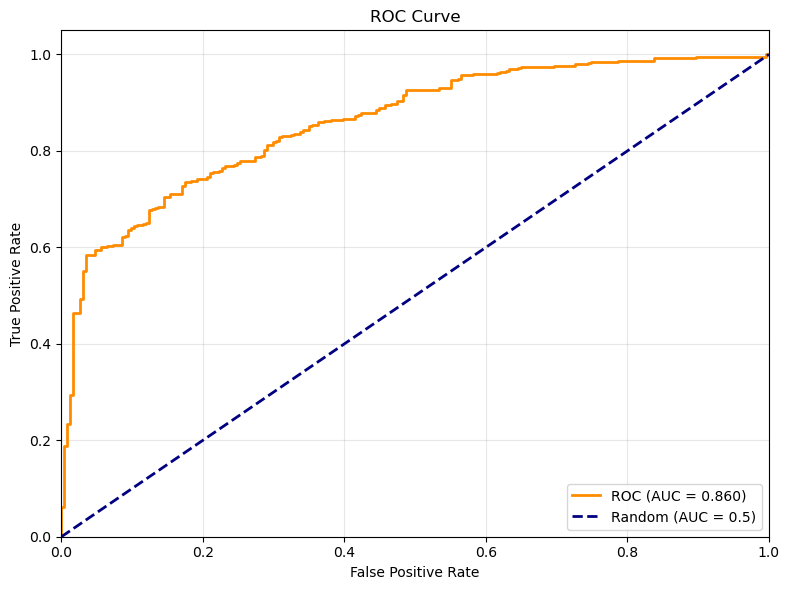

AUC: 0.8600


In [22]:
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC: {roc_auc:.4f}")


**Results Summary:** The AUC of 0.8600 indicates good discriminative ability, meaning the model can effectively distinguish between normal and pneumonia cases. An AUC above 0.8 is generally considered good performance, and this value suggests the model has a strong ability to rank cases correctly, with pneumonia cases typically receiving higher prediction scores than normal cases.


## Conclusion

This project developed and evaluated a convolutional neural network for pneumonia detection in chest X-ray images by combining the better-performing configurations from multiple experiments. The final model architecture consists of two convolutional-pooling blocks (16 and 32 filters) with ReLU activation, same padding, and strides=2 in the first layer. Regularization was achieved through batch normalization, dropout (0.5), early stopping, and strong data augmentation. The model was trained using an 80/20 split from the training directory, with the validation set augmented by combining it with images from the validation directory.

On the test set, the model achieved an overall accuracy of 75.80%, precision of 74.04%, recall of 94.36%, and an F1 score of 82.98%, with an AUC of 0.8600. The recall of 94.36% represents the model's strongest performance metric, demonstrating its ability to successfully identify most pneumonia cases. This high recall, which translates to a sensitivity of 94.36%, is particularly valuable in medical screening applications where detecting pneumonia cases is prioritized. The confusion matrix shows the model correctly identified 368 true positives and 105 true negatives, while producing 129 false positives and 22 false negatives, resulting in a specificity of 44.87%. The model's bias toward detecting pneumonia, reflected in the higher number of false positives relative to false negatives, aligns with the medical priority of minimizing missed cases.

The model's performance can be attributed to key design choices including regularization techniques, class weights to handle the imbalanced dataset, a balanced two-block architecture, and strong data augmentation. The approach of combining better settings from multiple experiments contributed to the model's development.

The results demonstrate the model's potential as a screening tool for pneumonia detection, with its high recall making it well-suited for initial screening where comprehensive case detection is prioritized. While the model achieves moderate overall accuracy, its strength lies in its ability to detect most pneumonia cases, making it suitable for scenarios where missing cases is more problematic than false alarms.

Future improvements could include threshold optimization to better balance precision and recall, transfer learning from pre-trained models to enhance feature extraction, validation on more diverse datasets to improve generalization, and ensemble methods or attention mechanisms to further enhance performance and interpretability.

In conclusion, the combined model demonstrates the effectiveness of integrating better configurations from multiple experiments, achieving high recall performance (94.36%) that makes it valuable for pneumonia screening applications. The overall accuracy of 75.80%, precision of 74.04%, F1 score of 82.98%, and AUC of 0.8600 collectively validate the approach and provide a foundation for further optimization and potential clinical deployment.
